In [1]:
# Please execute/shift-return this cell everytime you run the notebook.  Don't edit it. 
%load_ext autoreload
%autoreload 2
from notebook import * 

The key is already registered
Done loading notebook.py! We're good to go!


<div class="namebox">    
Double Click to edit and enter your

1.  Hugo Wan
2.  twan012
3.  twan012@ucr.edu
    
</div>

<div style=" font-size: 300% !important;
    margin-top: 1.5em;
    margin-bottom: 10px;
    font-weight: bold;
    line-height: 1.0;
    text-align:center;">
Programming Assignment/Lab 2: Optimizing LLMs for Cache Performnace!
</div>

**Welcome to the first programming assignment/lab of CS203!**

The main goals of this assignment/lab are:

1. Get familiar with performance profiling tools.
2. Get familiar with C/C++ and the development environment.
 
This assignment/lab will be completed on **your own**. 

Check Gradescope for due date(s).

## Browser Compatibility

We are still working out some bugs in some browsers.  Here's the current status:

1.  Chrome -- well tested.  Preferred option.
2.  Firefox -- seems ok, but not thoroughly tested.
3.  Edge -- seems ok, but not thoroughly tested.
4.  Safari -- not supported at the moment.
5.  Internet Explorer -- not supported at the moment.

At the moment, the authentication step must be done in Chrome.

## Keeping Your assignment/lab Up-to-Date

Occasionally, there will be changes made to the base repository after the
lab is released.  This may include bug fixes and updates to this document.  We'll post on piazza/edstem when an update is available.

In those cases, you can use the following commands to pull the changes from upstream and merge them into your code.  You'll need to do this at a shell.  It won't work properly in the notebook.  Save your notebook in the browser first.


```
cd <your directory for this assignment/lab>git remote add upstream $(cat .starter_repo)  # You need to do this once each time you checkout a new assignment/lab. It will fail 
                                              # harmlessly if you run it more than once.
cp assignment-lab.ipynb assignment-lab.backup.ipynb                 # Backup your work.
git commit -am "My progress so far."          # commit your work.
git pull upstream main --allow-unrelated-histories -X theirs # pull the updates
```

Or you can use the script we provide:

In [2]:
# Be sure to click save to preseve your progress before updating
! ./fix-repo
! ./pull-updates

fatal: remote upstream already exists.
cp: cannot stat 'assignment-lab.ipynb': No such file or directory
[main c933c19] My progress so far.
 3 files changed, 614 insertions(+), 92 deletions(-)
From github.com:CS203UCR/2025fa-cs203-llm-memory-starter
 * branch            main       -> FETCH_HEAD
Already up to date.


Then, reload this page in your browser.

## How To Use This Document

You will use Jupyter Notebook to complete this assignment/lab.  You should be able to do much of this assignment/lab without leaving Jupyter Notebook.  The main exception will be some of the programming chanllenges.  The instructions will make it clear when you should use the terminal.

### Running Code

Jupyter Notebooks are made up of "cells".  Some have Markdown-formatted text in them (like this one).  Some have Python code (like the one below).

For code cells, you press `shift-return` to execute the code.  Try it below:

In [3]:
print("I'm in python")

I'm in python


Code cells can also execute shell commands using the `!` operator.  Try it below:

In [4]:
!echo "I'm in a shell"

I'm in a shell


### Telling What The Notebook is Doing

The notebook will only run one cell at a time, so if you press `shift-return` several times, the cells will wait for one another.  You can tell that a cell is waiting if it there's a `*` in the `[]` to the left the cell:

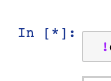


You'll can also tell _where_ the notebook is executing by looking at the table of contents on the left.  The section with the currently-executing cell will be red:

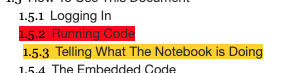

### What to Do Jupyter Notebook It Gets Stuck

First, check if it's actually stuck: Some of the cells take a while, but they will usually provide some visual sign of progress.  If _nothing_ is happening for more than 10 seconds, it's probably stuck.

To get it unstuck, you stop execution of the current cell with the "interrupt button":

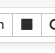

### Use VSCode

The container that we build for CS203 provides a more friendly "VSCode" environment. To launch that environment, you should find and press the `+` icon near the file menu.

![plus.png](plus.png)

The interface will move to a launcher where you may find the following VSCode icon.

![vscode.png](vscode.png)

Press that icon and then you can enjoy VSCode environment!

# Large Language Models

Large Language Models (LLMs) are a type of artificial intelligence that can understand and generate human-like text. They are built upon a neural network architecture called the Transformer, which allows them to process and learn from vast amounts of text data. Through a process called "pretraining," LLMs learn to predict the next word in a sequence, effectively learning the patterns, grammar, and even some factual knowledge embedded in the training data. This pretraining typically involves massive datasets and significant computational resources. After pretraining, LLMs can be fine-tuned for specific tasks like summarization, translation, or question answering.

This project is based on `llm.c` repository by Andrej Karpathy provides a minimalist implementation of large language model training in pure C/CUDA, aiming for simplicity and efficiency without relying on large frameworks like PyTorch. The `train_gpt2.h` file within this repository provides a set of primitives that supports training a GPT-2 model.

Here's how the main function of `train_gpt2.c` uses the functions in `train_gpt2.h` in implementing the training:

* **GPT-2 Reproduction:** The code is specifically designed to reproduce the training of a GPT-2 (124M parameter) model. This involves implementing the forward and backward passes for all the Transformer layers that constitute the GPT-2 architecture.
* **Data Handling:** It handles the loading and processing of training data, such as the tokenized Tiny Shakespeare dataset, and works with a GPT-2 tokenizer.
* **Optimization:** The training process uses the AdamW optimizer, a common choice for training deep learning models, to update the model's parameters based on the calculated gradients.
* **Training Loop:** The `main` function in `train_gpt2.c` contains the primary training loop. This loop iteratively performs the following steps:
    1.  **Forward Pass:** Input data (a batch of sequences) is fed through the GPT-2 model to produce output logits (predictions for the next token).
    2.  **Loss Calculation:** The difference between the predicted logits and the actual next tokens is quantified using a loss function (e.g., cross-entropy loss).
    3.  **Backward Pass (Backpropagation):** Gradients are calculated, indicating how much each parameter in the model contributes to the loss. This is done by propagating the error backward through the network.
    4.  **Parameter Update:** The AdamW optimizer uses these gradients to adjust the model's weights, aiming to minimize the loss in subsequent steps.
* **Simplified Approach:** Unlike more complex training setups, `train_gpt2.c` allocates all its GPU (or CPU) memory at the start, ensuring a constant memory footprint during training. It focuses on the fundamental arithmetic operations of neural network training, demonstrating that the process can be boiled down to a series of simple computations on float arrays.

Due to the significance of LLMs in modern AI applications, the performance of training LLM models matters when deploying applications. Based on Amdahl's Law, we should target the most time consuming function first. Even without any prior knowledge about, we can still know what's the most time-consuming function when training an LLM model through `perf record` and `perf report` as below.

**Notice: Training would take quite a long time -- about 6-10 minutes**

In [5]:
# Compile the code with the debug flag.
! make clean; make OPT_CFLAGS="-g" train_gpt2

---------------------------------------------
→ cuDNN is manually disabled by default, run make with `USE_CUDNN=1` to try to enable
✓ OpenMP found
✗ NCCL is not found, disabling multi-GPU support
---> On Linux you can try install NCCL with `sudo apt install libnccl2 libnccl-dev`
✓ MPI enabled
---------------------------------------------
rm -f train_gpt2 test_gpt2 my_test_gpt2 my_train_gpt2
rm -f build/*.o
---------------------------------------------
→ cuDNN is manually disabled by default, run make with `USE_CUDNN=1` to try to enable
✓ OpenMP found
✗ NCCL is not found, disabling multi-GPU support
---> On Linux you can try install NCCL with `sudo apt install libnccl2 libnccl-dev`
✓ MPI enabled
---------------------------------------------
cc -Ofast -Wno-unused-result -Wno-ignored-pragmas -Wno-unknown-attributes -DHAVE_LINUX_PERF_EVENT_H -march=native -g   train_gpt2.h train_gpt2.c perfstats.o -lm -o train_gpt2


In [6]:
# Run the "real" training process and record the profiled information.
! cs203 run "perf record ./train_gpt2 > perf.data"

Running on the cloud for: twan012@ucr.edu
check /proc/sys/kernel/kptr_restrict and /proc/sys/kernel/perf_event_paranoid.

Samples in kernel functions may not be resolved if a suitable vmlinux
file is not found in the buildid cache or in the vmlinux path.

Samples in kernel modules won't be resolved at all.

If some relocation was applied (e.g. kexec) symbols may be misresolved
even with a suitable vmlinux or kallsyms file.

Couldn't record kernel reference relocation symbol
Symbol resolution may be skewed if relocation was used (e.g. kexec).
Check /proc/kallsyms permission or run as root.
[GPT-2]
max_seq_len: 1024
vocab_size: 50257
padded_vocab_size: 50304
num_layers: 12
num_heads: 12
channels: 768
num_parameters: 124475904
train dataset num_batches: 1192
val dataset num_batches: 128
num_activations: 73347840
val loss 5.325522
step 0: train loss 4.677772 (took 17894.584162 ms)
step 1: train loss 5.191521 (took 17196.880805 ms)
step 2: train loss 4.438628 (took 17371.056769 ms)
step 3: 

In [7]:
render_csv("baseline.csv")

,Loss: 0,Loss: 1,Loss: 2,Loss: 3,Loss: 4,Loss: 5,Loss: 6,Loss: 7,Loss: 8,Loss: 9,Loss: 10,IC,Cycles,CPI,CT,ET,L1_dcache_miss_rate,L1_dcache_misses,L1_dcache_accesses
0,4.677772,5.191521,4.438628,4.138455,4.144234,3.834685,4.298057,4.280747,4.249753,4.391605,3.912614,1505597537395,659436566497,0.43799,0.439858,290.058261,0.091808,82541685330,899065207843


Now, we can use `perf report` to interpret the output as human-readable content using the following cell.

In [8]:
# Figure out the most time-consuming function.
! perf report --stdio > perf.out

Kernel address maps (/proc/{kallsyms,modules}) were restricted.

Check /proc/sys/kernel/kptr_restrict before running 'perf record'.

As no suitable kallsyms nor vmlinux was found, kernel samples
can't be resolved.

Samples in kernel modules can't be resolved as well.



The output file is really long, and the goal is never about optimizing everything. So we can use `head` command to see what's in the first 20 lines of the output.

In [9]:
! head -20 perf.out

# To display the perf.data header info, please use --header/--header-only options.
#
#
# Total Lost Samples: 0
#
# Samples: 974K of event 'cycles'
# Event count (approx.): 820183311972
#
# Overhead  Command     Shared Object     Symbol                          
# ........  ..........  ................  ................................
#
    31.78%  train_gpt2  train_gpt2        [.] matmul_backward
    24.36%  train_gpt2  train_gpt2        [.] matmul_forward
    20.57%  train_gpt2  train_gpt2        [.] gpt2_backward
    12.96%  train_gpt2  train_gpt2        [.] matmul_forward.constprop.0
     3.16%  train_gpt2  libm-2.31.so      [.] __expm1f
     1.30%  train_gpt2  libm-2.31.so      [.] __tanhf
     1.06%  train_gpt2  train_gpt2        [.] main
     0.93%  train_gpt2  train_gpt2        [.] attention_backward
     0.79%  train_gpt2  [unknown]         [k] 0xffffffff9cb0cdb5


Have you find which function takes the most significant amount of time? Is it the same as our last lab?

Through profiling the training process, we know `matmul_backward` in `train_gpt2.h` is the most time-consuming function. Let's dive in the code.

In [10]:
render_code("train_gpt2.h", show="matmul_backward")

// train_gpt2.h:226-263 (38 lines)
void matmul_backward(float* dinp, float* dweight, float* dbias,
                     const float* dout, const float* inp, const float* weight,
                     int B, int T, int C, int OC) {
    // most of the running time is spent here and in matmul_forward
    // this backward could be done in a single "round" of loops
    // but that doesn't afford an efficient parallelization strategy
    // backward into inp first, parallelize over B,T

    for (int b = 0; b < B; b++) {
        for (int t = 0; t < T; t++) {
            const float* dout_bt = dout + b * T * OC + t * OC;
            float* dinp_bt = dinp + b * T * C + t * C;
            for (int o = 0; o < OC; o++) {
                const float* wrow = weight + o*C;
                float d = dout_bt[o];
                for (int i = 0; i < C; i++) {
                    dinp_bt[i] += wrow[i] * d;
                }
            }
        }
    }
    // backward into weight/bias, parallelize over output channels OC
    for (int o = 0; o < OC; o++) {
        for (int b = 0; b < B; b++) {
            for (int t = 0; t < T; t++) {
                const float* dout_bt = dout + b * T * OC + t * OC;
                const float* inp_bt = inp + b * T * C + t * C;
                float* dwrow = dweight + o*C;
                float d = dout_bt[o];
                if (dbias != NULL) { dbias[o] += d; }
                for (int i = 0; i < C; i++) {
                    dwrow[i] += inp_bt[i] * d;
                }
            }
        }
    }

}

# Programming Assignment

{    "deletable": false,
    "editable": false}As you may imagine, this programming assignment is targeting at optimizing the most time consuming function(s) in the baseline `train_gpt2` to reducing the overall training time. In this project, your allowed to put your optimization in `my_train_gpt2.h` and we will compare the performance of `my_train_gpt2` with the baseline `train_gpt2`.

## Developing and testing

To save the develop time, we **strongly encourage** you to perform the testing of function optimizations using a scaled-down `test_gpt2` and `my_test_gpt2` programs. Where the `test_gpt2` include the baseline functions, and `my_test_gpt2` will use the `my_train_gpt2.h` functions.

In [11]:
!make clean test_gpt2 my_test_gpt2

---------------------------------------------
→ cuDNN is manually disabled by default, run make with `USE_CUDNN=1` to try to enable
✓ OpenMP found
✗ NCCL is not found, disabling multi-GPU support
---> On Linux you can try install NCCL with `sudo apt install libnccl2 libnccl-dev`
✓ MPI enabled
---------------------------------------------
rm -f train_gpt2 test_gpt2 my_test_gpt2 my_train_gpt2
rm -f build/*.o
cc -Ofast -Wno-unused-result -Wno-ignored-pragmas -Wno-unknown-attributes -DHAVE_LINUX_PERF_EVENT_H -march=native    train_gpt2.h test_gpt2.c perfstats.o -lm -o test_gpt2
cc -Ofast -Wno-unused-result -Wno-ignored-pragmas -Wno-unknown-attributes -DHAVE_LINUX_PERF_EVENT_H -march=native    my_train_gpt2.h my_test_gpt2.c perfstats.o -lm -o my_test_gpt2


In [12]:
!cs203 run "./test_gpt2"

Running on the cloud for: twan012@ucr.edu
[GPT-2]
max_seq_len: 1024
vocab_size: 50257
padded_vocab_size: 50304
num_layers: 12
num_heads: 12
channels: 768
num_parameters: 124475904
[State]
batch_size: 4
seq_len: 64
num_activations: 73347840
-43.431618, -43.431721
-39.836346, -39.836445
-43.065910, -43.065987
-42.828045, -42.828156
-43.529541, -43.529644
-44.318398, -44.318489
-41.227425, -41.227497
-41.270760, -41.270847
-42.541393, -42.541470
-42.394997, -42.395096
OK (LOGITS), max_diff = 8.850098e-04
LOSS OK: 5.269998 5.270009
dwte
OK -0.002320 -0.002320
OK 0.002072 0.002072
OK 0.003717 0.003717
OK 0.001307 0.001307
OK 0.000632 0.000632
TENSOR OK, maxdiff = 1.611710e-04
dwpe
OK -0.005111 -0.005110
OK -0.000011 -0.000012
OK -0.003262 -0.003262
OK 0.009909 0.009909
OK 0.002146 0.002145
TENSOR OK, maxdiff = 5.031005e-06
dln1w
OK -0.007523 -0.007523
OK 0.008642 0.008643
OK 0.005025 0.005029
OK -0.011094 -0.011095
OK -0.001663 -0.001664
TENSOR OK, maxdiff = 3.302675e-04
dln1b
OK -0.038462 

Beyond the timestamps the code provides, you may also read the performance counter based information as we generated below. The overall code has a miss rate of 8.2%. If you want, you can insert code in the target function for more detailed profiling and you will find the target function has a cache miss rate of 16%.

In [13]:
render_csv("baseline_test.csv")

,Loss: 0,Loss: 1,Loss: 2,Loss: 3,Loss: 4,IC,Cycles,CPI,CT,ET,L1_dcache_miss_rate,L1_dcache_misses,L1_dcache_accesses
0,5.269998,4.0597,3.375028,2.800781,2.315455,518291543201,306097492151,0.590589,0.276822,84.734389,0.082032,25766053914,314098776717


As our version resides in the `my_train_gpt2.h`, we also created a program `my_test_gpt2` to evaluate the effectiveness of our optimizations. You may run the following to compile your optimized version.

In [14]:
!make clean my_test_gpt2

---------------------------------------------
→ cuDNN is manually disabled by default, run make with `USE_CUDNN=1` to try to enable
✓ OpenMP found
✗ NCCL is not found, disabling multi-GPU support
---> On Linux you can try install NCCL with `sudo apt install libnccl2 libnccl-dev`
✓ MPI enabled
---------------------------------------------
rm -f train_gpt2 test_gpt2 my_test_gpt2 my_train_gpt2
rm -f build/*.o
cc -Ofast -Wno-unused-result -Wno-ignored-pragmas -Wno-unknown-attributes -DHAVE_LINUX_PERF_EVENT_H -march=native    my_train_gpt2.h my_test_gpt2.c perfstats.o -lm -o my_test_gpt2


If everything compiles, you may test your version using the following cell.

In [15]:
!cs203 run "./my_test_gpt2"

Running on the cloud for: twan012@ucr.edu
[GPT-2]
max_seq_len: 1024
vocab_size: 50257
padded_vocab_size: 50304
num_layers: 12
num_heads: 12
channels: 768
num_parameters: 124475904
[State]
batch_size: 4
seq_len: 64
num_activations: 73347840
-43.431618, -43.431721
-39.836346, -39.836445
-43.065910, -43.065987
-42.828045, -42.828156
-43.529541, -43.529644
-44.318398, -44.318489
-41.227425, -41.227497
-41.270760, -41.270847
-42.541393, -42.541470
-42.394997, -42.395096
OK (LOGITS), max_diff = 8.850098e-04
LOSS OK: 5.269998 5.270009
dwte
OK -0.002320 -0.002320
OK 0.002072 0.002072
OK 0.003717 0.003717
OK 0.001307 0.001307
OK 0.000632 0.000632
TENSOR OK, maxdiff = 1.611710e-04
dwpe
OK -0.005111 -0.005110
OK -0.000011 -0.000012
OK -0.003262 -0.003262
OK 0.009909 0.009909
OK 0.002146 0.002145
TENSOR OK, maxdiff = 5.031005e-06
dln1w
OK -0.007523 -0.007523
OK 0.008642 0.008643
OK 0.005025 0.005029
OK -0.011094 -0.011095
OK -0.001663 -0.001664
TENSOR OK, maxdiff = 3.302675e-04
dln1b
OK -0.038462 

In [16]:
render_csv("my_test.csv")

,Loss: 0,Loss: 1,Loss: 2,Loss: 3,Loss: 4,IC,Cycles,CPI,CT,ET,L1_dcache_miss_rate,L1_dcache_misses,L1_dcache_accesses
0,5.269998,4.0597,3.375028,2.800781,2.315455,536062711386,292720582668,0.546057,0.275623,80.680627,0.086849,26063900230,300105355566


## Final Evaluation

Remember, the program in the previous section is just a simplified version to test the performance. We are aiming at the complete training process with real data. Therefore, you will need to compile and test your program with the following two cells.

In [17]:
!make clean my_train_gpt2

---------------------------------------------
→ cuDNN is manually disabled by default, run make with `USE_CUDNN=1` to try to enable
✓ OpenMP found
✗ NCCL is not found, disabling multi-GPU support
---> On Linux you can try install NCCL with `sudo apt install libnccl2 libnccl-dev`
✓ MPI enabled
---------------------------------------------
rm -f train_gpt2 test_gpt2 my_test_gpt2 my_train_gpt2
rm -f build/*.o
cc -Ofast -Wno-unused-result -Wno-ignored-pragmas -Wno-unknown-attributes -DHAVE_LINUX_PERF_EVENT_H -march=native    my_train_gpt2.h my_train_gpt2.c perfstats.o -lm -o my_train_gpt2


In [18]:
!cs203 run "./my_train_gpt2"

Running on the cloud for: twan012@ucr.edu
[GPT-2]
max_seq_len: 1024
vocab_size: 50257
padded_vocab_size: 50304
num_layers: 12
num_heads: 12
channels: 768
num_parameters: 124475904
train dataset num_batches: 1192
val dataset num_batches: 128
num_activations: 73347840
val loss 5.325522
step 0: train loss 4.677772 (took 16987.667222 ms)
step 1: train loss 5.191521 (took 15741.192566 ms)
step 2: train loss 4.438628 (took 15744.799545 ms)
step 3: train loss 4.138455 (took 15751.149417 ms)
step 4: train loss 4.144234 (took 15758.036754 ms)
step 5: train loss 3.834685 (took 15733.669946 ms)
step 6: train loss 4.298057 (took 15750.973521 ms)
step 7: train loss 4.280747 (took 15787.745224 ms)
step 8: train loss 4.249753 (took 15726.353762 ms)
step 9: train loss 4.391605 (took 15723.841970 ms)
val loss 4.416495
generating:
---
grievously allowed it
That had shall say to him:
It is fair
that it be paid that a villager came
To the
---
step 10: train loss 3.912614 (took 15788.476854 ms)
Total: 2551

And you can see the performance counter based timing information through below. **You will need to achieve 1.2x on Gradescope (around the same speedup on our cluster) to receive full credits for this assignment. Only the performance number on Gradescope counts toward your grading**. The cluster and Gradescope use very similar CPU architectures. Therefore, the optimizations you applied should work on both sides.

In [19]:
render_csv("my_train.csv")

,Loss: 0,Loss: 1,Loss: 2,Loss: 3,Loss: 4,Loss: 5,Loss: 6,Loss: 7,Loss: 8,Loss: 9,Loss: 10,IC,Cycles,CPI,CT,ET,L1_dcache_miss_rate,L1_dcache_misses,L1_dcache_accesses
0,4.677772,5.191521,4.438628,4.138455,4.144234,3.834685,4.298057,4.280747,4.249753,4.391605,3.912614,1841607210898,924246705876,0.50187,0.276029,255.11903,0.097297,101777964103,1046049210461


When your submit your code for autograding, it'll run in a more tightly controlled way that let's us reliably measure performance and grade your submission. You can simulate it like this:

In [20]:
! python ./autograde.py  --submission . --results -

{
    "leaderboard": [
        {
            "name": " speedup",
            "value": 1.1465582947693083
        }
    ],
    "output": "",
    "stdout_visibility": "visible",
    "tests": [
        {
            "correctness": 10,
            "max_score": 100,
            "number": "1",
            "output": "tests passed",
            "score": 94.65582947693083,
            "speedup": 1.1465582947693083,
            "tags": [],
            "visibility": "visible"
        }
    ],
    "visibility": "visible"
}

If you ran the original code, it gets zero points (`"score": 0`).  Once you correctly modify `train_gpt2.h`, you'll get 100 point.

Once you are happy with your code, commit your changes to ``train_gpt2.h`.  You'll have to do this to turn it for official autograding.

In [21]:
!git commit -am "Yay! I finished the 2nd assignment!"
!git push

[main e3a29b3] Yay! I finished the 2nd assignment!
 2 files changed, 99 insertions(+), 75 deletions(-)
 delete mode 100755 my_test_gpt2
Enumerating objects: 16, done.
Counting objects: 100% (16/16), done.
Delta compression using up to 20 threads
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 19.45 KiB | 1.39 MiB/s, done.
Total 12 (delta 9), reused 0 (delta 0)
remote: Resolving deltas: 100% (9/9), completed with 4 local objects.
To github.com:CS203UCR/2025fa-cs203-llm-memory-HugoWan0504.git
   e28847b..e3a29b3  main -> main


**If this asks you for a password, it means you forgot some initial steps in the README.md file of this repo. You'll need to interrupt your Jupyter notebook kernel and follow the exact steps in the README.md before you can start again.**

## Useful C++ Tips

There are few things in C++ that might be useful in this assignment.

### Controlling Compiler Optimizations

First, you can prevent inlining of a particular function by declaring it like so:

```
void __attribute__((noinline)) join_solution(...)
```

This can make it easier to debug, because you can set a breakpoint on the function and it'll work like you expect.

Second, you can turn on arbitrary optimizations for particular functions like so:

```
#pragma GCC push_options
#pragma GCC optimize ("unroll-loops")

void your_function() {
}

#pragma GCC pop_options
```


### Assertions

The `assert()` macro is useful tool for debugging and to avoid silly errors.

If you say

```
assert(a > b);
```

And the expression is not true at run time, the assert with "fail" your program will crash with a somewhat useful error message.

This is a useful way to document and enforce assumptions you make in your code.  For instance, I used an assert in `convolution_tiled_split()` to ensure that the tile size was > 8.

You can get access to  `assert()` with 

```
#include<cassert>
```

The overhead of asserts is low, but not zero.  I would not put any in one of your performance-critical loops.

If you want to include asserts in performance-critical areas, you can add `-DNDEBUG` to the optimizations in `config.make`.  It'll disable all the `assert()`s.


### Debugging 

Your code will certainly have errors in it, and you'll need to debug.  THe first thing you need to do is to tone down the optimizations, because they make debugging almost impossible.  Recall that `-Og` is the right flag to use for optimization while debugging:

In [22]:
!make clean my_test_gpt2 OPT_CFLAGS="-g"

---------------------------------------------
→ cuDNN is manually disabled by default, run make with `USE_CUDNN=1` to try to enable
✓ OpenMP found
✗ NCCL is not found, disabling multi-GPU support
---> On Linux you can try install NCCL with `sudo apt install libnccl2 libnccl-dev`
✓ MPI enabled
---------------------------------------------
rm -f train_gpt2 test_gpt2 my_test_gpt2 my_train_gpt2
rm -f build/*.o
cc -Ofast -Wno-unused-result -Wno-ignored-pragmas -Wno-unknown-attributes -DHAVE_LINUX_PERF_EVENT_H -march=native -g   my_train_gpt2.h my_test_gpt2.c perfstats.o -lm -o my_test_gpt2


Unfortunately, the Linux debugger `gdb` doesn't work inside the note book.  If you want to use it, you can do so at the terminal:

```
$ gdb ./my_test_gpt2
GNU gdb (Ubuntu 9.2-0ubuntu1~20.04.2) 9.2
Copyright (C) 2020 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.
Type "show copying" and "show warranty" for details.
This GDB was configured as "x86_64-linux-gnu".
Type "show configuration" for configuration details.
For bug reporting instructions, please see:
<http://www.gnu.org/software/gdb/bugs/>.
Find the GDB manual and other documentation resources online at:
    <http://www.gnu.org/software/gdb/documentation/>.

For help, type "help".
Type "apropos word" to search for commands related to "word"...
Reading symbols from ./my_test_gpt2...
(gdb) 
```

The best place to start is at `matmul_backward`.  From there you can step into your solution code.

```
bash$ gdb 
(gdb) break matmul_backward
Breakpoint 1 at 0x9fd0: matmul_backward. (2 locations)
```

Sometimes that will note give a good result, even without optimizations.  Instead, you can set a break point at a line number:

```
bash$ gdb alloc_main.exe
(gdb) break join_solution.hpp:47
(gdb) run --function join_solution_c --size 100  --power 2
(gdb) list
```

There's a pretty good `gdb` [tutorial here](https://www.cs.cmu.edu/~gilpin/tutorial/).


## Hint

As the naming of the function, this is essentially a function contains two main loops, both of which are essentially matrix-vector or matrix-matrix multiplication-like operations. This function has already performed quite a few optimizations.

Let's deep dive into the code.

  * **First Loop (Calculating `dinp_bt`):**

    ```c++
    for (int b = 0; b < B; ++b) {
        for (int t = 0; t < T; ++t) {
            const float* dout_bt = dout + (b * T + t) * OC;
            float* dinp_bt = dinp + (b * T + t) * C;

            for (int o = 0; o < OC; ++o) {
                const float d = dout_bt[o];
                const float* wrow = weight + o * C; // Accessing a row of 'weight'

                // Cache-friendly access: contiguous wrow[i]
                for (int i = 0; i < C; ++i) {
                    dinp_bt[i] += wrow[i] * d;
                }
            }
        }
    }
    ```

      * `dout_bt[o]` is accessed sequentially, which is good.
      * `dinp_bt[i]` is accessed sequentially, which is good.
      * `wrow[i]` (a row of `weight`) is accessed sequentially, which is good.
      * **Potential Issue:** The `o` loop is the outermost for `weight` access within the inner `i` loop. This means that for each `(b, t)` pair, we iterate `OC` times, and each time we read a *different* row of `weight` (`wrow`). If `OC` is large and `C` is large, or if `weight` is large, `weight` rows might be evicted from cache before they are reused across `(b, t)` iterations if there was a way to reorder. However, `weight` is only read. The main write is to `dinp_bt`. `dinp_bt` is written `OC` times for each `(b,t)` slice. This means that `dinp_bt` (a `C`-sized array) is repeatedly read, modified, and written back `OC` times. If `C` is large and `OC` is large, `dinp_bt` might be evicted from cache between `o` iterations, leading to misses.

  * **Second Loop (Calculating `dweight` and `dbias`):**

    ```c++
    for (int o = 0; o < OC; ++o) {
        float* dwrow = dweight + o * C; // Writing to a row of 'dweight'

        float bias_accum = 0.0f;

        for (int b = 0; b < B; ++b) {
            for (int t = 0; t < T; ++t) {
                const float* dout_bt = dout + (b * T + t) * OC;
                const float* inp_bt = inp + (b * T + t) * C;

                const float d = dout_bt[o]; // Accesses a specific element of dout_bt
                bias_accum += d;

                for (int i = 0; i < C; ++i) {
                    dwrow[i] += inp_bt[i] * d;
                }
            }
        }

        if (dbias != NULL) {
            dbias[o] += bias_accum;
        }
    }
    ```

      * `dwrow[i]` (a row of `dweight`) is written sequentially, which is good. This row is accumulated over all `(b, t)` iterations.
      * `inp_bt[i]` is accessed sequentially, which is good.
      * `dout_bt[o]` is accessed. This is the `o`-th element of `dout_bt`.
      * **Major Cache Issue:** The outer loop is `o`. Inside, we iterate `B` then `T`. For each `o`, we iterate through all `(b, t)` pairs. This means `inp_bt` and `dout_bt` (which are essentially rows/vectors of large matrices) are accessed non-contiguously *across the `o` loop*. Specifically, `dout_bt[o]` accesses a *column* of the `dout` matrix (considering `(b*T+t)` as rows and `o` as columns). Similarly, `inp_bt[i]` is part of a `C`-sized vector, but `inp_bt` changes across `b` and `t`. This "column-major" like access for `dout` and `inp` within the `o` loop is a significant cache performance bottleneck.

1.  **Loop Reordering (for the second loop):** The most impactful change for the second loop is to reorder the loops to maximize spatial locality. The goal is to access `dout` and `inp` sequentially.

      * The `i` loop accesses `dwrow` and `inp_bt` contiguously. This should remain the innermost.
      * The `b` and `t` loops iterate through the "batches" and "time steps" which determine the base addresses of `dout_bt` and `inp_bt`.
      * The `o` loop iterates through the output channels/columns.
      * If we move the `o` loop inwards, we can achieve better locality for `dout` and `inp`.

2.  **Loop Tiling/Blocking (potentially for both loops, especially if `B`, `T`, `C`, `OC` are very large):** This technique breaks down the loops into smaller "tiles" that can fit into the cache. This helps maximize data reuse within the cache before data is evicted. This is more complex to implement and might introduce some overhead, but is crucial for very large problems.

3.  **Minimizing Redundant Address Calculations:** Compilers are generally good at this, but explicit local pointers help clarity and might assist the compiler.


<div class="alert alert-block alert-danger">

**Only Gradescope Counts** The scores produced here **do not** count.  Only gradescope counts.  The results here should match what Gradescope does, but I would test your solution on Gradescope well-ahead of the deadline to ensure your code is working like you expect.
    
</div>

<div class="alert alert-block alert-success">

<div class="question-text">

### References used in the project    

We do not expect everyone to know the answers at the very beginning and looking for resources to solve problems is a common practice in engineering. However, it is also important to know what can you use in these assignments and give them good enough credits through citations! 

In real practice, not everything online can be used due to the copyright and licensing issues. Therefore, it is a nice habit to keep track of your references all the time and review if they're eligible.
    
In CS203, you're allowed to seek for help from the following **independently**.

1. Public code repositories with proper license (e.g. MIT license) -- please provide the repos.
2. Research papers/textbooks -- please cite them below.
3. Generative AI -- please describe the prompt you used.
    
In contrast, you're **NOT allowed** to seek for help from the following.
1. Using code from others
2. Asking and discussing with other people except for teaching staffs.

</div>
</div>

<div class="alert alert-block alert-success">
<div class="answer">

If you have used any outside resource to finish the programming assignment, please cite each of them properly below. Without citation to the resources you used, we will consider your assignment cheating if we found similar somewhere else.

</div>
</div>

# Turning in the programming assignment/lab


You need to turn in your notebook and your programming assignment/lab in the specific gradescope item.  
After you complete the assignment/lab, you will turn it in by submitting your latest github repository.

**Step 1:**  Save your workbook!!!

In [23]:
!for i in 1 2 3 4 5; do echo Save your files!!; sleep 1; done

Save your files!!
Save your files!!
Save your files!!
Save your files!!
Save your files!!


**Step 2:**  Commit everything. Please run the following command.

In [24]:
!git commit -am "Yay! I am ready to turn in!"
!git push

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	my_test_gpt2

nothing added to commit but untracked files present (use "git add" to track)
Everything up-to-date


**Step 3**: 
Submit through gradescope
You'll turn in your programming assignment by providing gradescope with your github repo of this assignment.   It'll run the autograder and return the results.